In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import cv2
import imageio
import getpass

import azure.storage.blob
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient


from tensorflow.keras.models import Model
import tensorflow.keras as keras
import tensorflow as tf
from keras.callbacks import Callback

import sys
sys.path.append('../ml-workflow/') # point to wherever the ml-workflow directory is
import imp

import data_utils as du
import ml_models

from tqdm.auto import trange, tqdm
import concurrent.futures

# Need to comment out gray_image = cv2.cvtColor(ri, cv2.COLOR_BGR2GRAY) in du.prepocess_input
# gray_image = ri
from importlib import reload
reload(du)


<module 'data_utils' from 'C:\\Users\\ysman\\Desktop\\Capstone\\PIVOT\\../ml-workflow\\data_utils.py'>

In [2]:
df = pd.read_parquet("inventory_df_with_probs.parquet.gzip")

In [4]:
df.head()

,Index,image_path,pred_label,pred_class,index,0,1,2,3,4,5,6,7,8,9
0,0,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,0,0.003190,2.078881e-11,8.588634e-05,0.000173,8.921839e-08,0.003271,8.093556e-06,0.957533,0.035501,0.000237
1,1,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,1,0.007551,5.126985e-07,3.592776e-04,0.002601,2.534480e-06,0.204228,1.017940e-03,0.718851,0.061205,0.004183
2,2,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,9,NaN,2,0.000135,1.200640e-11,1.257837e-05,0.000220,2.652156e-05,0.000103,1.847491e-07,0.390917,0.000375,0.608209
3,3,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,3,0.001123,1.054870e-14,4.769512e-05,0.000167,1.587807e-10,0.013132,1.304258e-05,0.984470,0.000259,0.000788
4,4,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,4,0.000100,7.816149e-09,8.546382e-08,0.008106,8.124642e-09,0.343707,2.029714e-05,0.645359,0.000388,0.002319


In [115]:
def least_confident_score(x):
    return 1 - np.max(x)

def least_margin_score(x):
    sort_x = np.sort(x)
    return 1 - (sort_x[-1] - sort_x[-2])

def entropy_score(x):
    return -x.T @ np.nan_to_num(np.log(x))

def get_score(x, f):
    try:
        s = f(x)
    except:
        print(f"Error computing {f.__name__}")
        s = -1
    return s

In [125]:
%%time
for f in tqdm([
#     least_confident_score, 
    least_margin_score, 
#     entropy_score
]):
    df[str(f.__name__)] = df[list(np.arange(10).astype(int).astype(str))].apply(lambda x: get_score(x,f), axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 29.6 s
Wall time: 30.8 s


In [137]:
df.head()

,Index,image_path,pred_label,pred_class,index,0,1,2,3,4,5,6,7,8,9,entropy_score,least_confident_score,least_margin_score
0,0,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,0,0.003190,2.078881e-11,8.588634e-05,0.000173,8.921839e-08,0.003271,8.093556e-06,0.957533,0.035501,0.000237,0.201498,0.042467,0.077968
1,1,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,1,0.007551,5.126985e-07,3.592776e-04,0.002601,2.534480e-06,0.204228,1.017940e-03,0.718851,0.061205,0.004183,0.817881,0.281149,0.485377
2,2,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,9,NaN,2,0.000135,1.200640e-11,1.257837e-05,0.000220,2.652156e-05,0.000103,1.847491e-07,0.390917,0.000375,0.608209,0.676992,0.391791,0.782708
3,3,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,3,0.001123,1.054870e-14,4.769512e-05,0.000167,1.587807e-10,0.013132,1.304258e-05,0.984470,0.000259,0.000788,0.089775,0.015530,0.028662
4,4,/Users/alisonchase/Documents/IFCB/NAAMES/NAAME...,7,Other,4,0.000100,7.816149e-09,8.546382e-08,0.008106,8.124642e-09,0.343707,2.029714e-05,0.645359,0.000388,0.002319,0.706994,0.354641,0.698348


In [157]:
df[['pred_label', 'pred_class']].drop_duplicates().sort_values(by='pred_label').reset_index(drop=True)

,pred_label,pred_class
0,0,Chloro
1,1,Cilliate
2,2,Crypto
3,3,Diatom
4,4,Dictyo
5,5,Dinoflagellate
6,6,Eugleno
7,7,Other
8,8,Prymnesio
9,9,NaN


Note that all 9s are NaN

In [146]:
df_no_probs = df.drop(columns=list(np.arange(10).astype(int).astype(str)))
df_no_probs.to_parquet("inventory_df_with_scores.parquet.gzip", index=False, compression='gzip')

### Check Rank-Order

In [2]:
df = pd.read_parquet("inventory_df_with_scores.parquet.gzip")

In [159]:
df_no_probs.drop(columns = ['index'], inplace=True)

In [161]:
df_no_probs[['entropy_score', 'least_confident_score', 'least_margin_score']]

,entropy_score,least_confident_score,least_margin_score
0,0.201498,0.042467,0.077968
1,0.817881,0.281149,0.485377
2,0.676992,0.391791,0.782708
3,0.089775,0.015530,0.028662
4,0.706994,0.354641,0.698348
...,...,...,...
1055995,0.234404,0.057854,0.112909
1055996,1.129720,0.399378,0.606505
1055997,1.289111,0.385930,0.545256
1055998,0.526977,0.174938,0.332709


In [163]:
import pandas as pd
from scipy.stats import spearmanr

# Assuming df is your DataFrame with the given columns
# Replace df with your actual DataFrame name

columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Calculate Spearman rank correlation coefficients and p-values
cor_entropy_vs_confident, p_value_entropy_vs_confident = spearmanr(df["entropy_score"], df["least_confident_score"])
cor_entropy_vs_margin, p_value_entropy_vs_margin = spearmanr(df["entropy_score"], df["least_margin_score"])
cor_confident_vs_margin, p_value_confident_vs_margin = spearmanr(df["least_confident_score"], df["least_margin_score"])

# Display results
print(f"Spearman Rank Correlation Coefficients:")
print(f"entropy_score vs least_confident_score: {cor_entropy_vs_confident}, p-value: {p_value_entropy_vs_confident}")
print(f"entropy_score vs least_margin_score: {cor_entropy_vs_margin}, p-value: {p_value_entropy_vs_margin}")
print(f"least_confident_score vs least_margin_score: {cor_confident_vs_margin}, p-value: {p_value_confident_vs_margin}")


Spearman Rank Correlation Coefficients:
entropy_score vs least_confident_score: 0.9964544145451807, p-value: 0.0
entropy_score vs least_margin_score: 0.9927704277719999, p-value: 0.0
least_confident_score vs least_margin_score: 0.9990185759491628, p-value: 0.0


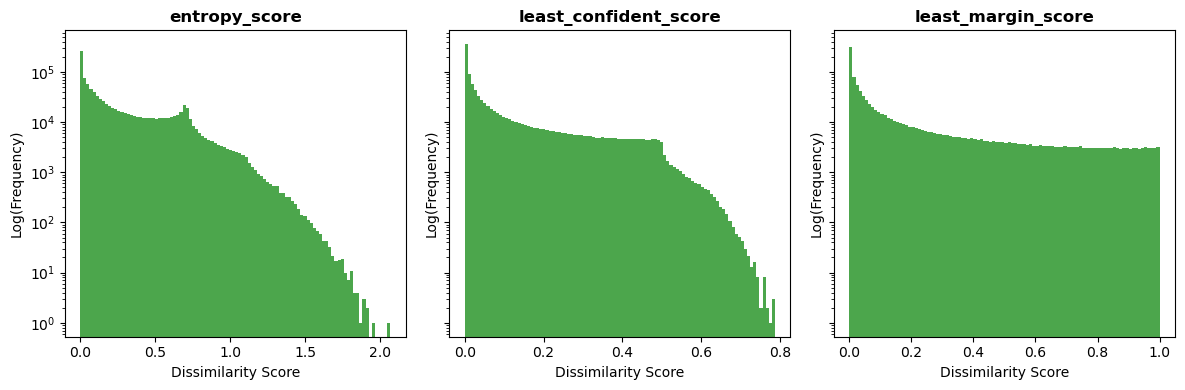

In [5]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare), nrows=1, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(columns_to_compare):
    # Plot log-histogram of values
    axes[i].hist(df[col], bins=100, color='green', alpha=0.7)
    axes[i].set_title(f'{col}', weight='bold')
    axes[i].set_xlabel('Dissimilarity Score')
    axes[i].set_ylabel('Log(Frequency)')
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()


In [200]:
df_ranks.astype(int).sort_values(by = 'entropy_score')

,entropy_score,least_confident_score,least_margin_score
3163,1,102,2
7474,2,183,4
8219,3,188,5
8343,4,191,6
9673,5,203,9
...,...,...,...
670965,1055996,1055914,1027005
961125,1055997,1055970,1045129
722824,1055998,1055986,1049603
256206,1055999,1055957,1034886


CPU times: total: 984 ms
Wall time: 992 ms


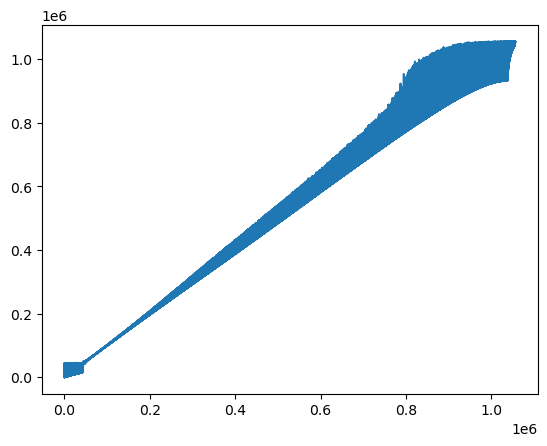

In [7]:
%%time
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

plt.plot(df_ranks.astype(int).sort_values(by = 'least_confident_score')['least_confident_score'],
         df_ranks.astype(int).sort_values(by = 'least_confident_score')['entropy_score']
        )

In [ ]:
%%time
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

plt.plot(df_ranks.astype(int).sort_values(by = 'least_confident_score')['least_confident_score'],
         df_ranks.astype(int).sort_values(by = 'least_confident_score')['entropy_score']
        )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

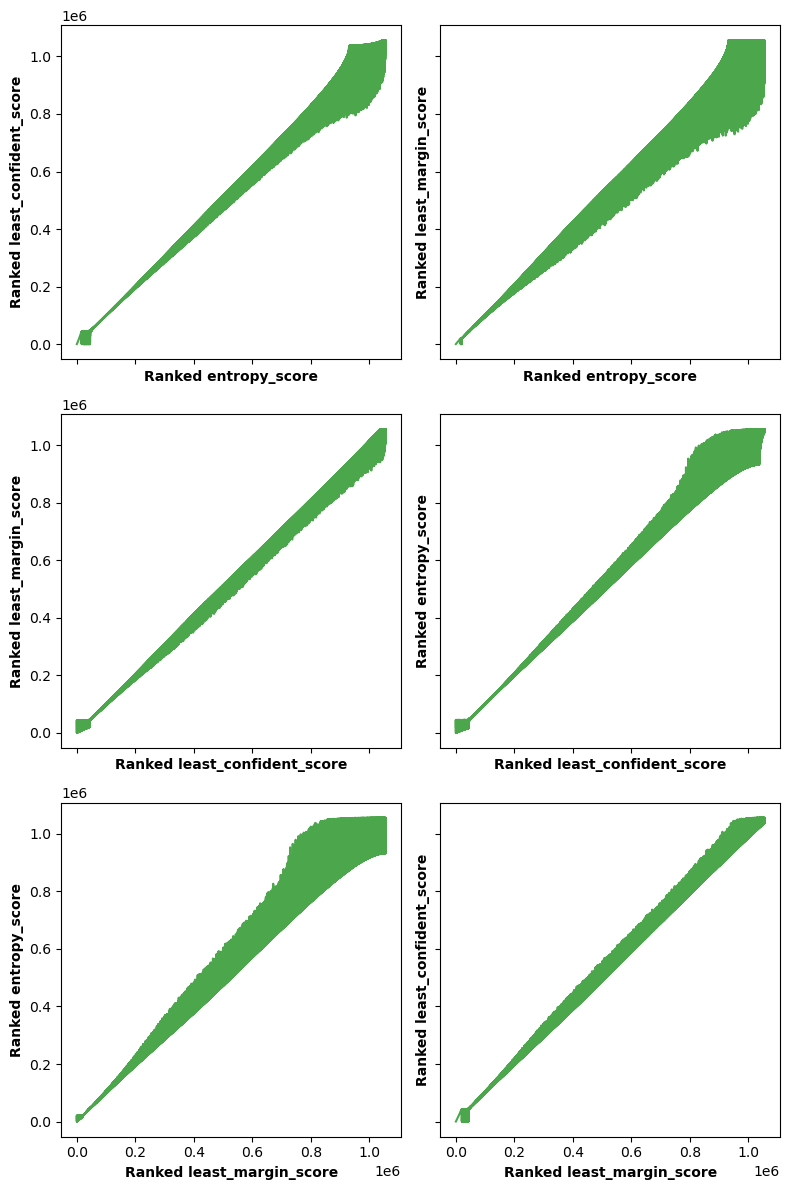

In [11]:
columns_to_compare = ["entropy_score", "least_confident_score", "least_margin_score"]

# Convert numerical columns to ranks
df_ranks = df[columns_to_compare].rank(method='first').astype(int)

# Set up subplots for each column
fig, axes = plt.subplots(ncols=len(columns_to_compare)-1, 
                         nrows=len(columns_to_compare), 
                         figsize=(8, 12), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.5)

for i, col in enumerate(tqdm(columns_to_compare)):
    # Plot log-histogram of values
    tmp_df = df_ranks.sort_values(by=f'{col}')
    for j in trange(1, len(columns_to_compare)):
        col_j = columns_to_compare[(i+j) % len(columns_to_compare)]
        axes[i,j-1].plot(tmp_df[col], tmp_df[col_j], color='green', alpha=0.7)
#         axes[i,j].set_title(f'{col}', weight='bold')
        axes[i,j-1].set_xlabel(f'Ranked {col}', weight='bold')
        axes[i,j-1].set_ylabel(f'Ranked {col_j}', weight='bold')
#     axes[i].set_yscale('log')

plt.tight_layout()
# plt.savefig("rank_comparisons.png", dpi=400)


In [ ]:
df[columns_to_compare].rank()